In [1]:
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import graphlearning as gl
import sklearn.datasets as datasets

sys.path.append("./src/")

# loading bar
from tqdm.notebook import tqdm
# from tqdm import tqdm

# for NearestNeighbor
from annoy import AnnoyIndex

# my own modules
from nn import MLP
from util import prepare_dataset
from util import spectral_layout

# for graph
import networkx as nx
import scipy.sparse as sp

# sensitivity analysis
from torch.autograd.functional import jacobian

from scipy.sparse.linalg import ArpackNoConvergence

# for deep copy
import copy

# larger canvas
# plt.rcParams["figure.figsize"] = (10, 8)

# clearer canvas
# plt.rcParams["figure.dpi"] = 300

# smaller font
# plt.rcParams["font.size"] = 3

# spectral clustering 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralClustering

# set the device
if not torch.backends.mps.is_available() and not torch.cuda.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current PyTorch install was not "
            "built with MPS enabled."
        )
    else:
        print(
            "MPS not available because the current MacOS version is not 12.3+ "
            "and/or you do not have an MPS-enabled device on this machine."
        )
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available on this machine.")
else:
    device = torch.device("mps")
    print("MPS is available on this machine.")

# set global seed for torch
torch.manual_seed(0)
np.random.seed(0)

# interactive mode
%matplotlib widget

CUDA is available on this machine.


/home/dinple/Github/NNEvo/.conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dinple/Github/NNEvo/.conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
if not os.path.exists("saved_model"):
    os.makedirs("saved_model")

if not os.path.exists("saved_model/MNIST/"):
    os.makedirs("saved_model/MNIST/")

In [3]:
DATASET = "mnist"

# prepare dataset
train_dataset = prepare_dataset(dataset=DATASET, iftrain=True)
test_dataset = prepare_dataset(dataset=DATASET, iftrain=False)

print("train_dataset.data.shape: ", train_dataset.data.shape)
print("train_dataset.targets.shape: ", train_dataset.targets.shape)

# to mps device
train_dataset.data = train_dataset.data.to(device)
train_dataset.targets = train_dataset.targets.to(device)
test_dataset.data = test_dataset.data[:140].to(device)
test_dataset.targets =  test_dataset.targets[:140].to(device)

train_dataset.data.shape:  torch.Size([60000, 28, 28])
train_dataset.targets.shape:  torch.Size([60000])


poi_indices.shape:  (1000,)
poi_indices:  [1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88, 95, 108, 114, 118, 119, 121, 156, 169, 192, 206, 209, 210, 216, 229, 232, 234, 246, 249, 260, 283, 293, 296, 303, 320, 326, 359, 399, 427, 429, 435, 440, 451, 453, 458, 462, 464, 473, 489, 519, 524, 526, 527, 542, 577, 582, 596, 603, 612, 633, 639, 656, 662, 666, 667, 668, 669, 689, 702, 709, 712, 733, 743, 745, 776, 781, 787, 790, 818, 825, 849, 859, 860, 869, 872, 889, 903, 927, 943, 949, 952, 957, 965, 979, 984, 997, 1000, 1015, 1018, 3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, 78, 99, 102, 104, 105, 112, 113, 124, 128, 134, 152, 174, 177, 184, 200, 201, 205, 208, 211, 224, 231, 248, 251, 269, 270, 276, 290, 309, 310, 315, 345, 351, 355, 357, 358, 366, 382, 394, 397, 398, 406, 408, 416, 443, 447, 450, 454, 455, 466, 470, 475, 484, 491, 492, 507, 508, 510, 533, 535, 538, 552, 553, 556, 572, 573, 587, 593, 604, 609, 618, 637, 638, 648, 671, 676, 678, 691, 698, 710, 711, 738, 747, 765, 779, 780, 

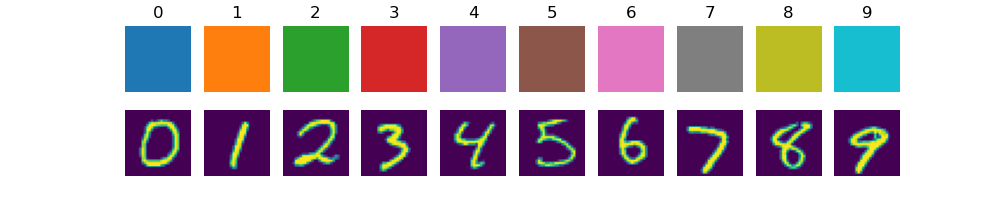

In [4]:
# randomly select 100 samples from each class
poi_indices = []
for i in range(10):
    poi_indices.append(torch.where(train_dataset.targets == i)[0][:100])
poi_indices = torch.cat(poi_indices).cpu().detach().numpy()

print("poi_indices.shape: ", poi_indices.shape)
print("poi_indices: ", poi_indices.tolist())

colors = sns.color_palette(None, 10)
colors = np.array(colors)

# plot two rows, first row is the color blocks, second row is the random sample from each class
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(colors[i].reshape(1, 1, 3))
    # print class name
    plt.title("{}".format(i))
    plt.axis("off")
    plt.subplot(2, 10, i+11)
    plt.imshow(test_dataset.data[test_dataset.targets == i][1].cpu().detach().numpy().reshape(28, 28))
    # print class name
    # plt.title("{}".format(i))
    plt.axis("off")

plt.show()

In [5]:
# prepare model
model = MLP(784, 100, 10)
# if model is already trained, load it
if os.path.exists("saved_model/MNIST/model.pt"):
    print("Loading model...")
    model.load_state_dict(torch.load("saved_model/MNIST/model.pt"))
    model.to(device)
else:
    print("No model found, training...")
    model.to(device)
    # prepare optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    # train
    model.train(x=train_dataset.data, y=train_dataset.targets, optimizer=optimizer, criterion=criterion, epochs=10000, verbose=True)
    # save model
    torch.save(model.state_dict(), "saved_model/MNIST/model.pt")

No model found, training...
[INFO] Epoch 0 Loss: 17.869232177734375
[INFO] Epoch 100 Loss: 0.6978635191917419
[INFO] Epoch 200 Loss: 0.41538310050964355
[INFO] Epoch 300 Loss: 0.3043254315853119
[INFO] Epoch 400 Loss: 0.2422059178352356
[INFO] Epoch 500 Loss: 0.20310631394386292
[INFO] Epoch 600 Loss: 0.1753838062286377
[INFO] Epoch 700 Loss: 0.15458011627197266
[INFO] Epoch 800 Loss: 0.1382167935371399
[INFO] Epoch 900 Loss: 0.12495817989110947
[INFO] Epoch 1000 Loss: 0.11385828256607056
[INFO] Epoch 1100 Loss: 0.10412281006574631
[INFO] Epoch 1200 Loss: 0.09569995105266571
[INFO] Epoch 1300 Loss: 0.08804720640182495
[INFO] Epoch 1400 Loss: 0.08113964647054672
[INFO] Epoch 1500 Loss: 0.07408293336629868
[INFO] Epoch 1600 Loss: 0.06785683333873749
[INFO] Epoch 1700 Loss: 0.06208575516939163
[INFO] Epoch 1800 Loss: 0.05710654333233833
[INFO] Epoch 1900 Loss: 0.05224774032831192
[INFO] Epoch 2000 Loss: 0.047730620950460434
[INFO] Epoch 2100 Loss: 0.04575468227267265
[INFO] Epoch 2200 Los

In [6]:
# evaluate on original data
print("[INFO] Evaluating on original data...")
pred = model.forward(test_dataset.data)
print("     Accuracy: ", accuracy_score(test_dataset.targets.cpu().detach().numpy(), pred.argmax(dim=1).cpu().detach().numpy()))

# rotate the data by 90 degrees
print("[INFO] Evaluating on data rotated by 90 degrees...")
test_data_rot90 = torch.rot90(test_dataset.data, 1, [1, 2])
# evaluate
pred = model.forward(test_data_rot90)
print("     Accuracy: ", accuracy_score(test_dataset.targets.cpu().detach().numpy(), pred.argmax(dim=1).cpu().detach().numpy()))

# rotate the data by 180 degrees
print("[INFO] Evaluating on data rotated by 180 degrees...")
test_data_rot180 = torch.rot90(test_dataset.data, 2, [1, 2])
# evaluate
pred = model.forward(test_data_rot180)
print("     Accuracy: ", accuracy_score(test_dataset.targets.cpu().detach().numpy(), pred.argmax(dim=1).cpu().detach().numpy()))

# rotate the data by 270 degrees
print("[INFO] Evaluating on data rotated by 270 degrees...")
test_data_rot270 = torch.rot90(test_dataset.data, 3, [1, 2])
# evaluate
pred = model.forward(test_data_rot270)
print("     Accuracy: ", accuracy_score(test_dataset.targets.cpu().detach().numpy(), pred.argmax(dim=1).cpu().detach().numpy()))

[INFO] Evaluating on original data...
     Accuracy:  0.9357142857142857
[INFO] Evaluating on data rotated by 90 degrees...
     Accuracy:  0.9714285714285714
[INFO] Evaluating on data rotated by 180 degrees...
     Accuracy:  0.9428571428571428
[INFO] Evaluating on data rotated by 270 degrees...
     Accuracy:  0.9357142857142857


# TODO 
- What could be the problem? Shuffle the combination?